In [34]:
import numpy as np
import pandas as pd 
import datetime as dt 
import alphalens as alpha
from pandas_datareader import data as pdr 

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 

In [35]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :
                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date',str(ticker)]
            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date',str(ticker)]
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)

        return Price_DF

# ------------ Company_DF parameters ------------ 
start   = dt.datetime(2012,1,1)
end     = dt.datetime.now()
tickers = ['AAPL',"MSFT","SHOP","INTC","TSLA","JPM","MS","GS","BAC","UBS",]

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
Stock_DF 

,AAPL,MSFT,SHOP,INTC,TSLA,JPM,MS,GS,BAC,UBS
Date,,,,,,,,,,
2012-01-03,14.686786,26.770000,0.000000,24.540001,5.616000,34.980000,16.080000,95.360001,5.800000,12.380000
2012-01-04,14.765714,27.400000,0.000000,25.110001,5.542000,34.950001,15.940000,94.739998,5.810000,12.330000
2012-01-05,14.929643,27.680000,0.000000,25.400000,5.424000,35.680000,16.280001,94.580002,6.310000,11.880000
2012-01-06,15.085714,28.110001,0.000000,25.250000,5.382000,35.360001,15.900000,93.419998,6.180000,11.620000
2012-01-09,15.061786,27.740000,0.000000,25.469999,5.450000,35.299999,16.200001,94.690002,6.270000,11.280000
...,...,...,...,...,...,...,...,...,...,...
2021-08-16,151.119995,294.600006,1489.000000,53.470001,686.169983,158.929993,103.720001,408.350006,41.290001,17.070000
2021-08-17,150.190002,293.079987,1481.869995,52.689999,665.710022,157.009995,102.870003,404.970001,41.090000,16.870001
2021-08-18,146.360001,290.730011,1489.180054,52.189999,688.989990,155.580002,101.260002,398.799988,40.790001,16.780001


In [36]:
class MyFactor():


    def __init__(self,Stock_Data):

        self.Stock_Data = Stock_Data 

    def DataFrame(self,Method):

        # tickers & store_list 
        tickers = []
        Factors = []
        cols = self.Stock_Data.columns

        # factor 
        if Method == "Momentum" :

            Method = self.Momentum

        # start calculate
        for i in range(len(cols)):
            
            # data & calcluation
            price  = Stock_DF[str(cols[i])].to_list()
            Factor = Method(price)

            # store value
            tickers.append(cols[i])
            Factors.append(Factor)

        # output factor dataframe
        Factor_DF = pd.DataFrame()
        Factor_DF['Tickers']             = tickers
        Factor_DF[str(Method.__name__)+" Factor"] = Factors
        Factor_DF = Factor_DF.sort_values(by=str(Method.__name__)+" Factor",ascending=False).reset_index(drop=True)

        return Factor_DF


    def Momentum(self,prices):

        Change_in_Over_the_year  = (prices[-21] - prices[-252]) / prices[-252]
        Change_in_Over_the_month = (prices[-1] - prices[-21]) / prices[-21] 

        # handle returns inf value problem
        returns  = pd.Series(prices).pct_change()
        returns.replace([np.inf, -np.inf], np.nan, inplace=True)
        returns = returns.dropna()

        # price change in over time / standarized 
        Momentum_Factor  = ( Change_in_Over_the_year - Change_in_Over_the_month ) / np.nanstd(returns, axis=0)

        return Momentum_Factor 


Factor    = MyFactor(Stock_Data = Stock_DF)
Factor_DF = Factor.DataFrame(Method="Momentum")
Factor_DF

,Tickers,Momentum Factor
0,GS,44.840259
1,MS,38.822411
2,JPM,30.764530
3,BAC,21.926332
4,SHOP,20.357588
5,MSFT,19.131778
6,TSLA,14.555975
7,UBS,13.990881
8,AAPL,10.954264
9,INTC,5.120161


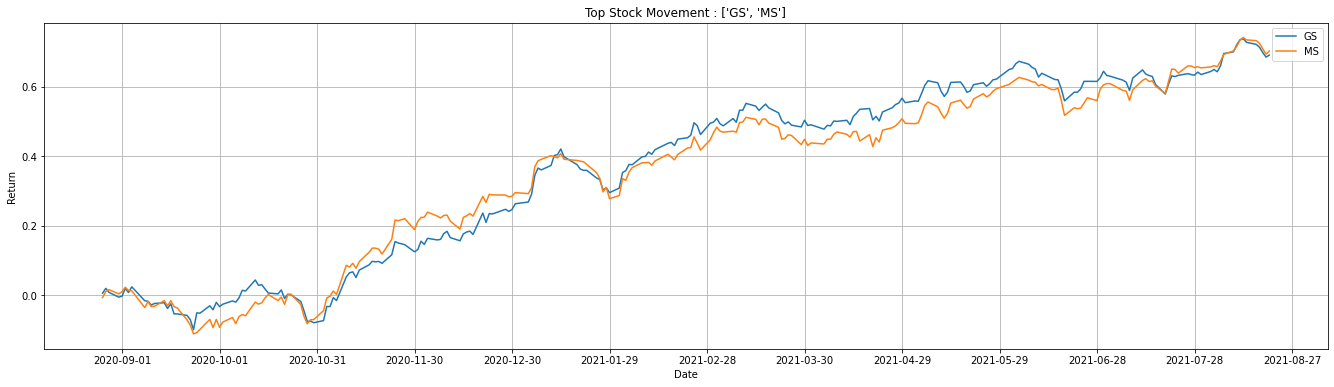

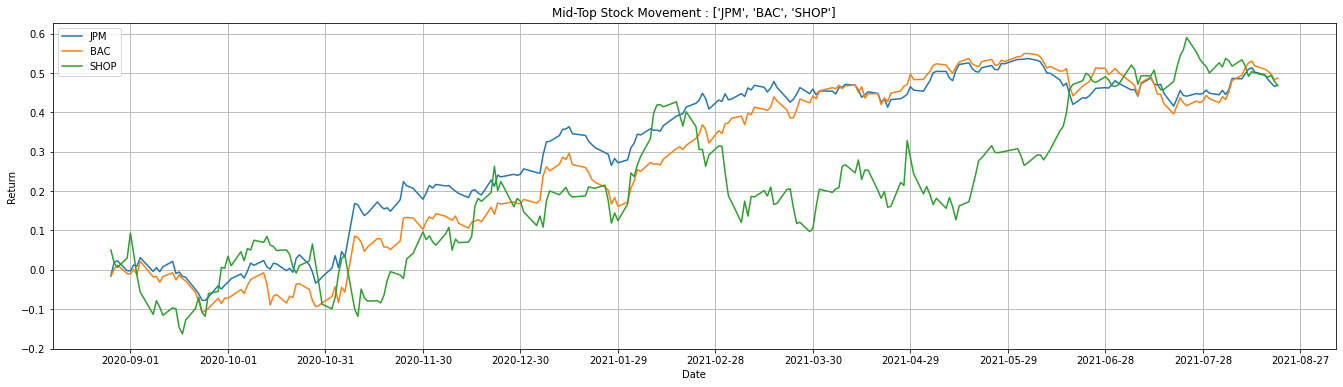

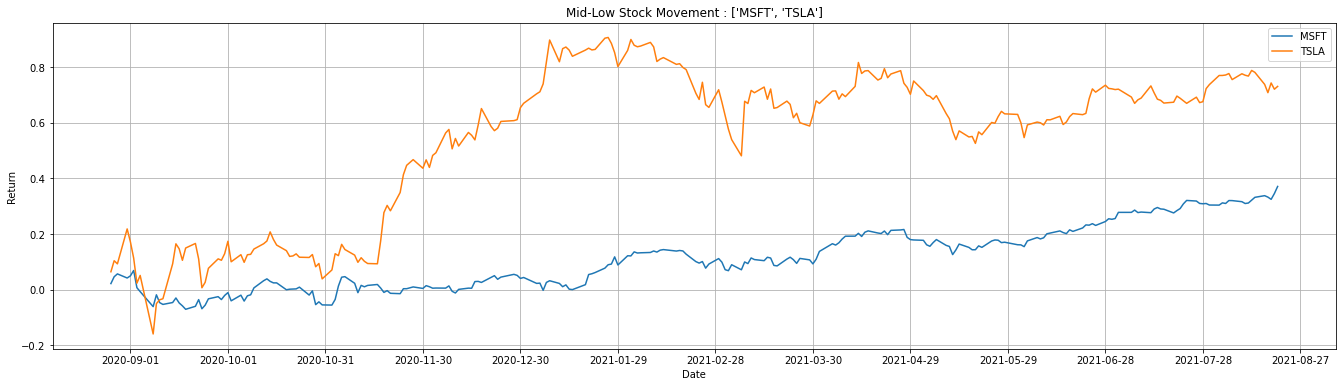

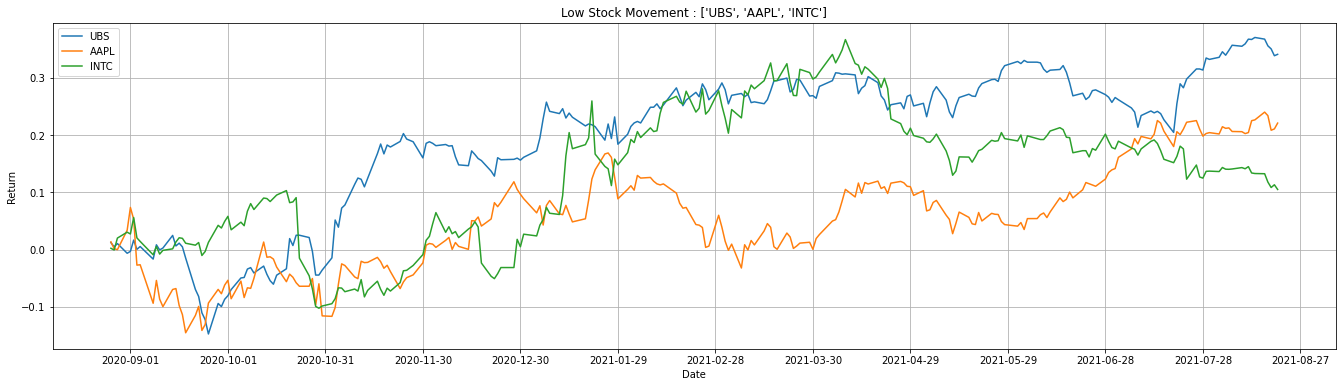

In [38]:
# Quantial stock Movement 

# sotck df , factor df

def Plot_Factor_Quantial_Movement(Stock_DF,Factor_DF,Type) :

    PLOT_DF          = Stock_DF.tail(250)
    cols             = Factor_DF['Tickers'].to_list()

    # cumulative returns dataframe
    if Type == "Returns" :

        PLOT_DF= PLOT_DF.pct_change().dropna()
        PLOT_DF.replace([np.inf, -np.inf], np.nan, inplace=True)
        PLOT_DF = PLOT_DF.dropna()
        PLOT_DF = PLOT_DF.cumsum()
        

    TQ_fig,TQ_ax   = plt.subplots(figsize=(23,6))
    MTQ_fig,MTQ_ax = plt.subplots(figsize=(23,6))
    MDQ_fig,MDQ_ax = plt.subplots(figsize=(23,6))
    DQ_fig,DQ_ax   = plt.subplots(figsize=(23,6))

    Top_Quntial_stock_list     = cols[:int(len(cols)*0.25)]
    UP_Mid_Quntial_stock_list   = cols[int(len(cols)*0.25):int(len(cols)*0.5)]
    Down_Mid_Quntial_stock_list  = cols[int(len(cols)*0.5):int(len(cols)*0.75)]
    Down_Quntial_stock_list       = cols[int(len(cols)*0.75):]


    for i in range(len(cols)):

        # top 25
        if str(cols[i]) in Top_Quntial_stock_list : 
            TQ_ax.plot(PLOT_DF.index,PLOT_DF[str(cols[i])],label=str(cols[i]))

        # down 25
        elif str(cols[i]) in Down_Quntial_stock_list : 
            DQ_ax.plot(PLOT_DF.index,PLOT_DF[str(cols[i])],label=str(cols[i]))

        # mid-top 25
        if str(cols[i]) in UP_Mid_Quntial_stock_list : 
            MTQ_ax.plot(PLOT_DF.index,PLOT_DF[str(cols[i])],label=str(cols[i]))

        # mid-down 25
        elif str(cols[i]) in Down_Mid_Quntial_stock_list : 
            MDQ_ax.plot(PLOT_DF.index,PLOT_DF[str(cols[i])],label=str(cols[i]))


    TQ_ax.title.set_text('Top Stock Movement : '+str(Top_Quntial_stock_list))
    DQ_ax.title.set_text('Low Stock Movement : '+str(Down_Quntial_stock_list))
    MTQ_ax.title.set_text('Mid-Top Stock Movement : '+str(UP_Mid_Quntial_stock_list))
    MDQ_ax.title.set_text('Mid-Low Stock Movement : '+str(Down_Mid_Quntial_stock_list))

    TQ_fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    DQ_fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    MTQ_fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    MDQ_fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

    TQ_ax.legend()
    DQ_ax.legend()
    MTQ_ax.legend()
    MDQ_ax.legend()

    TQ_ax.grid()
    DQ_ax.grid()
    MTQ_ax.grid()
    MDQ_ax.grid()

    TQ_ax.set_xlabel('Date')
    TQ_ax.set_ylabel('Return')
    DQ_ax.set_xlabel('Date')
    DQ_ax.set_ylabel('Return')
    MTQ_ax.set_xlabel('Date')
    MTQ_ax.set_ylabel('Return')
    MDQ_ax.set_xlabel('Date')
    MDQ_ax.set_ylabel('Return')
    
    plt.show()

    return Top_Quntial_stock_list,UP_Mid_Quntial_stock_list,Down_Mid_Quntial_stock_list,Down_Quntial_stock_list


Top_Quntial_stock_list,UP_Mid_Quntial_stock_list,Down_Mid_Quntial_stock_list,Down_Quntial_stock_list = Plot_Factor_Quantial_Movement(Stock_DF,Factor_DF,Type='Returns')